##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Federated Learning for Text Generation

In [62]:
# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# !pip install --quiet tensorflow_federated
# !pip install --quiet tf-nightly

# NOTE: Jupyter requires a patch to asyncio.
# !pip install --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [89]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

# Pre-processing

## Load distributed data

In [90]:
import glob

In [92]:
path = '../data/flocking**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {}
cnt = 0

for filename in glob.iglob(path):
    for line in open(filename):
        data = line.split(',')
        if len(data) == 6:
            rid = data[0]
            x1 = float(data[2])
            x2 = float(data[3])
            if rid in samples.keys():
                last_key = list(samples[rid].keys())[-1]
                samples[rid][last_key].append((x1, x2))
            else:
                samples.update({rid: {}})
                samples[rid].update({0: []})
        else:
            last_key = list(samples[rid].keys())[-1]
            samples[rid][last_key + 1] = []
            

# print(samples['10'][2])
# print(samples['1'].keys())
# print(samples.keys())


## Visualize Data

In [83]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

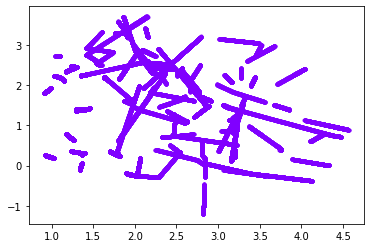

In [96]:
TIME_STEP = 0.1

colors = cm.rainbow(np.linspace(0, 1, len(samples.keys())))
cnt = 0


plt.figure()
for v in samples.values():
    for traj in v.values():
        t = np.arange(0, TIME_STEP * len(traj))
        if (len(traj) > 0):
            x, y = zip(*traj)
        plt.plot(x, y, '.', color=colors[cnt])
    break
    cnt += 1
plt.show( )

## Create Labels

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Pre-train a model

We load a model that was pre-trained following the TensorFlow tutorial.
http://trajnet.stanford.edu/


## Load the pre-trained model and generate some text

In [ ]:
EMBEDDING_SIZE = 32

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(EMBEDDING_SIZE))
model.add(tf.keras.layers.LSTM(8))

In [4]:
def load_model(batch_size):
  urls = {
      1: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch1.kerasmodel',
      8: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch8.kerasmodel'}
  assert batch_size in urls, 'batch_size must be in ' + str(urls.keys())
  url = urls[batch_size]
  local_file = tf.keras.utils.get_file(os.path.basename(url), origin=url)  
  return tf.keras.models.load_model(local_file, compile=False)

In [5]:
def generate_text(model, start_string):
  # From https://www.tensorflow.org/tutorials/sequences/text_generation
  num_generate = 200
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  temperature = 1.0

  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(
        predictions, num_samples=1)[-1, 0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [7]:
# Text generation requires a batch_size=1 model.
keras_model_batch1 = load_model(batch_size=1)
print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask? '))

What of TensorFlow Federated, you ask? Splay, or Death, that the worst friend) fortately at Calais, that answered her hand he
was--am I hope, but very bad! As I see
Herself. Again then, it was his ordital to the drinking-table
with his 


# Load and Preprocess the Federated Shakespeare Data

The `tff.simulation.datasets` package provides a variety of datasets that are split into "clients", where each client corresponds to a dataset on a particular device that might participate in federated learning.

These datasets provide realistic non-IID data distributions that replicate in simulation the challenges of training on real decentralized data. Some of the pre-processing of this data was done using tools from the [Leaf project](https://arxiv.org/abs/1812.01097) ([github](https://github.com/TalwalkarLab/leaf)).

In [0]:
train_data, test_data = tff.simulation.datasets.shakespeare.load_data()

The datasets provided by `shakespeare.load_data()` consist of a sequence of
string `Tensors`, one for each line spoken by a particular character in a
Shakespeare play. The client keys consist of the name of the play joined with
the name of the character, so for example `MUCH_ADO_ABOUT_NOTHING_OTHELLO` corresponds to the lines for the character Othello in the play *Much Ado About Nothing*. Note that in a real federated learning scenario
clients are never identified or tracked by ids, but for simulation it is useful
to work with keyed datasets.

Here, for example, we can look at some data from King Lear:

In [0]:
# Here the play is "The Tragedy of King Lear" and the character is "King".
raw_example_dataset = train_data.create_tf_dataset_for_client(
    'THE_TRAGEDY_OF_KING_LEAR_KING')
# To allow for future extensions, each entry x
# is an OrderedDict with a single key 'snippets' which contains the text.
for x in raw_example_dataset.take(2):
  print(x['snippets'])

tf.Tensor(, shape=(), dtype=string)
tf.Tensor(What?, shape=(), dtype=string)


We now use `tf.data.Dataset` transformations to prepare this data for training the char RNN loaded above. 


In [0]:
# Input pre-processing parameters
SEQ_LENGTH = 100
BATCH_SIZE = 8
BUFFER_SIZE = 10000  # For dataset shuffling

In [0]:
# Using a namedtuple with keys x and y as the output type of the
# dataset keeps both TFF and Keras happy:
BatchType = collections.namedtuple('BatchType', ['x', 'y'])

# Construct a lookup table to map string chars to indexes,
# using the vocab loaded above:
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=vocab, values=tf.constant(list(range(len(vocab))),
                                       dtype=tf.int64)),
    default_value=0)


def to_ids(x):
  s = tf.reshape(x['snippets'], shape=[1])
  chars = tf.strings.bytes_split(s).values
  ids = table.lookup(chars)
  return ids


def split_input_target(chunk):
  input_text = tf.map_fn(lambda x: x[:-1], chunk)
  target_text = tf.map_fn(lambda x: x[1:], chunk)
  return BatchType(input_text, target_text)


def preprocess(dataset):
  return (
      # Map ASCII chars to int64 indexes using the vocab
      dataset.map(to_ids)
      # Split into individual chars
      .unbatch()
      # Form example sequences of SEQ_LENGTH +1
      .batch(SEQ_LENGTH + 1, drop_remainder=True)
      # Shuffle and form minibatches
      .shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
      # And finally split into (input, target) tuples,
      # each of length SEQ_LENGTH.
      .map(split_input_target))

Note that in the formation of the original sequences and in the formation of
batches above, we use `drop_remainder=True` for simplicity. This means that any
characters (clients) that don't have at least `(SEQ_LENGTH + 1) * BATCH_SIZE`
chars of text will have empty datasets. A typical approach to address this would
be to pad the batches with a special token, and then mask the loss to not take
the padding tokens into account.

This would complicate the example somewhat, so for this tutorial we only use full batches, as in the
[standard tutorial](https://www.tensorflow.org/tutorials/sequences/text_generation).
However, in the federated setting this issue is more significant, because many
users might have small datasets.

Now we can preprocess our `raw_example_dataset`, and check the types:

In [0]:
example_dataset = preprocess(raw_example_dataset)
print(tf.data.experimental.get_structure(example_dataset))

BatchType(x=TensorSpec(shape=(8, 100), dtype=tf.int64, name=None), y=TensorSpec(shape=(8, 100), dtype=tf.int64, name=None))


# Compile the model and test on the preprocessed data


We loaded an uncompiled keras model, but in order to run `keras_model.evaluate`, we need to compile it with a loss and metrics. We will also compile in an optimizer, which will be used as the on-device optimizer in Federated Learning.

The original tutorial didn't have char-level accuracy (the fraction
of predictions where the highest probability was put on the correct
next char). This is a useful metric, so we add it.
However, we need to define a new metric class for this because 
our predictions have rank 3 (a vector of logits for each of the 
`BATCH_SIZE * SEQ_LENGTH` predictions), and `SparseCategoricalAccuracy`
expects only rank 2 predictions.

In [0]:
class FlattenedCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):

  def __init__(self, name='accuracy', dtype=None):
    super(FlattenedCategoricalAccuracy, self).__init__(name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, len(vocab), 1])
    return super(FlattenedCategoricalAccuracy, self).update_state(
        y_true, y_pred, sample_weight)

In [0]:
def compile(keras_model):
  keras_model.compile(
      optimizer=tf.keras.optimizers.SGD(lr=0.5),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[FlattenedCategoricalAccuracy()])
  return keras_model

Now we can compile a model, and evaluate it on our `example_dataset`.

In [37]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
keras_model = load_model(batch_size=BATCH_SIZE)

compile(keras_model)

# Confirm that loss is much lower on Shakespeare than on random data
print('Evaluating on an example Shakespeare character:')
keras_model.evaluate(example_dataset.take(1))

# As a sanity check, we can construct some completely random data, where we expect
# the accuracy to be essentially random:
random_indexes = np.random.randint(
    low=0, high=len(vocab), size=1 * BATCH_SIZE * (SEQ_LENGTH + 1))
data = {
    'snippets':
        tf.constant(''.join(np.array(vocab)[random_indexes]), shape=[1, 1])
}
random_dataset = preprocess(tf.data.Dataset.from_tensor_slices(data))
print('\nExpected accuracy for random guessing: {:.3f}'.format(1.0 / len(vocab)))
print('Evaluating on completely random data:')
keras_model.evaluate(random_dataset, steps=1)

Evaluating on an example Shakespeare character:
      1/Unknown - 1s 1s/step - loss: 2.9296 - accuracy: 0.4412
Expected accuracy for random guessing: 0.012
Evaluating on completely random data:
1/1 [==============================] - 0s 426ms/step - loss: 11.4698 - accuracy: 0.0125


[11.4698486328125, 0.0125]

# Fine-tune the model with Federated Learning

TFF serializes all TensorFlow computations so they can potentially be run in a
non-Python environment (even though at the moment, only a simulation runtime implemented in Python is available). Even though we are running in eager mode, (TF 2.0), currently TFF serializes TensorFlow computations by constructing the
necessary ops inside the context of a "`with tf.Graph.as_default()`" statement.
Thus, we need to provide a function that TFF can use to introduce our model into
a graph it controls. We do this as follows:

In [0]:
# Clone the keras_model inside `create_tff_model()`, which TFF will
# call to produce a new copy of the model inside the graph that it will serialize.
def create_tff_model():
  # TFF uses a `dummy_batch` so it knows the types and shapes
  # that your model expects.
  x = tf.constant(np.random.randint(1, len(vocab), size=[BATCH_SIZE, SEQ_LENGTH]))
  dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
  keras_model_clone = compile(tf.keras.models.clone_model(keras_model))
  return tff.learning.from_compiled_keras_model(
      keras_model_clone, dummy_batch=dummy_batch)

Now we are ready to construct a Federated Averaging iterative process, which we will use to improve the model (for details on the Federated Averaging algorithm, see the paper [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/abs/1602.05629)).

We use a compiled Keras model to perform standard (non-federated) evaluation after each round of federated training. This is useful for research purposes when doing simulated federated learning and there is a  standard test dataset. 

In a realistic production setting this same technique might be used to take models trained with federated learning and evaluate them on a centralized benchmark dataset for testing or quality assurance purposes.

In [0]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.build_federated_averaging_process(model_fn=create_tff_model)

Here is the simplest possible loop, where we run federated averaging for one round on a single client on a single batch:

In [0]:
state = fed_avg.initialize()
state, metrics = fed_avg.next(state, [example_dataset.take(1)])
print(metrics)

<accuracy=0.016249999404,loss=4.45304775238>


Now let's write a slightly more interesting training and evaluation loop.

So that this simulation still runs relatively quickly,  we train on the same three clients each round, only considering two minibatches for each.



In [0]:
def data(client, source=train_data):
  return preprocess(
      source.create_tf_dataset_for_client(client)).take(2)

clients = ['ALL_S_WELL_THAT_ENDS_WELL_CELIA',
           'MUCH_ADO_ABOUT_NOTHING_OTHELLO',
           'THE_TRAGEDY_OF_KING_LEAR_KING']

train_datasets = [data(client) for client in clients]

# We concatenate the test datasets for evaluation with Keras.
test_dataset = functools.reduce(
    lambda d1, d2: d1.concatenate(d2),
    [data(client, test_data) for client in clients])

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
# instead to use the default reference runtime.
if six.PY3:
  tff.framework.set_default_executor(tff.framework.create_local_executor())

The initial state of the model produced by `fed_avg.initialize()` is based
on the random initializers for the Keras model, not the weights that were loaded,
since `clone_model()` does not clone the weights. To start training
from a pre-trained model, we set the model weights in the server state
directly from the loaded model.

In [0]:
NUM_ROUNDS = 3

# The state of the FL server, containing the model and optimization state.
state = fed_avg.initialize()

state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in keras_model.trainable_weights],
    non_trainable_weights=[
        v.numpy() for v in keras_model.non_trainable_weights
    ])


def keras_evaluate(state, round_num):
  tff.learning.assign_weights_to_keras_model(keras_model, state.model)
  print('Evaluating before training round', round_num)
  keras_model.evaluate(example_dataset, steps=2)


for round_num in range(NUM_ROUNDS):
  keras_evaluate(state, round_num)
  # N.B. The TFF runtime is currently fairly slow,
  # expect this to get significantly faster in future releases.
  state, metrics = fed_avg.next(state, train_datasets)
  print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

Evaluating before training round 0
2/2 [==============================] - 1s 649ms/step - loss: 3.2126 - accuracy: 0.4288
Training metrics:  <accuracy=0.413541674614,loss=3.30218100548>
Evaluating before training round 1
2/2 [==============================] - 1s 561ms/step - loss: 2.8153 - accuracy: 0.4588
Training metrics:  <accuracy=0.434791654348,loss=2.98462796211>
Evaluating before training round 2
2/2 [==============================] - 1s 601ms/step - loss: 2.7724 - accuracy: 0.4575
Training metrics:  <accuracy=0.437916666269,loss=2.87845301628>
Evaluating before training round 4
2/2 [==============================] - 1s 645ms/step - loss: 2.7769 - accuracy: 0.4444


With the default changes, we haven't done enough training to make a big difference, but if you train longer on more Shakespeare data, you should see a difference in the style of the text generated with the updated model:

In [0]:
keras_model_batch1.set_weights([v.numpy() for v in keras_model.weights])
# Text generation requires batch_size=1
print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask? '))

What of TensorFlow Federated, you ask? Says it with the knitting.
g of a spy, kept from such hopes to a passenger, whom, one. Piploing And my will be a moment!" said Monsieur Defarge.


There were more than twice, went them, and clieding


# Suggested extensions

This tutorial is just the first step! Here are some ideas for how you might try extending this notebook:
  * Write a more realistic training loop where you sample clients to train on randomly.
  * Use "`.repeat(NUM_EPOCHS)`" on the client datasets to try multiple epochs of local training (e.g., as in [McMahan et. al.](https://arxiv.org/abs/1602.05629)). See also [Federated Learning for Image Classification](federated_learning_for_image_classification.md) which does this.
  * Change the `compile()` command to experiment with using different optimization algorithms on the client.
  * Try the `server_optimizer` argument to `build_federated_averaging_process` to try different algorithms for applying the model updates on the server.
  * Try the `client_weight_fn` argument to to `build_federated_averaging_process` to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. `client_weight_fn=lambda _: tf.constant(1.0)`.